## Install the following libraries, if not done already, before running the below script

#### !pip install tensorflow
#### !pip install scikit-learn
#### !pip install numpy 
#### !pip install pandas 
#### !pip install pyDOE 
#### !pip install scipy
#### !pip install matplotlib
#### !pip install pypickle

In [ ]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import GroupShuffleSplit
import pickle

# Ensure reproducibility
np.random.seed(42)
tf.random.set_random_seed(42)


# Material constant ranges from Table 1
material_constant_ranges = {
    "E": [191000e6, 195000e6],  # Young's modulus in MPa
    "sigma_y": [90e6, 120e6],  # Yield stress in MPa
    "h": [50,100],  # Isotropic hardening rate
}
# Generate material constants using Latin Hypercube Sampling
def generate_material_constants_lhs(num_samples, ranges):
    num_variables = len(ranges)
    lhs_samples = lhs(num_variables, samples=num_samples)
    material_constants = []

    for i, (key, (low, high)) in enumerate(ranges.items()):
        samples = lhs_samples[:, i] * (high - low) + low
        material_constants.append(samples)

    return np.column_stack(material_constants)



def generate_strain_history(epsilon_0, a, num_strain_samples):
    # Parameters
    steps = np.linspace(0, num_strain_samples, num_strain_samples)  # Steps from 0 to 4000
    frequency = a / num_strain_samples  # Frequency for three cycles
    initial_amplitude = epsilon_0  # Initial amplitude
    amplitude_growth_rate = 0.00002  # Rate at which amplitude increases

    # Compute the amplitude as a function of steps
    amplitude_modulation = initial_amplitude + amplitude_growth_rate * steps

    # Generate the sine wave with varying amplitude
    strain = amplitude_modulation * np.sin(2 * np.pi * frequency * steps)
    
    return strain


# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, h, alpha, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    yield_function = np.abs(sigma_trial) - (sigma_y + h * alpha)
    return sigma_trial, yield_function


# Von Mises return mapping algorithm
def von_mises(eps, eps_p, sigma_trial, yield_function, alpha, h, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        sigma_updated = sigma_trial
        eps_p = eps_p
        alpha = alpha
        delta_gamma=0
        sign = sigma_trial/np.abs(sigma_trial)
    else:
        # Plastic step
        delta_gamma = yield_function / (E + h)
        eps_p = eps_p + delta_gamma* (sigma_trial/np.abs(sigma_trial))
        alpha = alpha + delta_gamma
        #sigma_updated = sigma_trial - E * delta_gamma
        sigma_updated = E*(eps-eps_p)
        sign = sigma_trial/np.abs(sigma_trial)

    return sigma_updated, eps_p, alpha, delta_gamma, sign



# Generate dataset
def generate_dataset(epsilon_0, a, num_strain_samples):
    
    dataset = []
    material_constants = generate_material_constants_lhs(num_samples, ranges)
    #print(material_constants)
    
    for constants in material_constants:
        
        E, sigma_y, h = constants
        strain_history = generate_strain_history(epsilon_0, a, num_strain_samples)

        # Initialize state variables
        alpha, eps_p = 0, 0
    
        for eps in strain_history:
            # Elastic predictor
            sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, h, alpha, sigma_y)

            # Return mapping algorithm
            sigma_updated, eps_p, alpha, delta_gamma, sign  = von_mises(eps, eps_p, sigma_trial, yield_function, alpha, h, E, sigma_y)

            # Store the data
            dataset.append([
                E,sigma_y,h, yield_function, eps, sigma_updated, eps_p, alpha, sign, np.abs(delta_gamma)
            ])

    return np.array(dataset)


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_von_mises_training_07_01_2025.csv"):
    columns = ["E","sigma_y","h", "yield_function", "strain", "sigma_updated", "cummulative eps_p", "alpha",'sign', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")


In [2]:
def normalize_dataset(data, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(data)
    else:
        normalized_data = scaler.transform(data)
    return normalized_data, scaler

In [3]:
# Build the neural network
def build_model(input_dim):
    model = Sequential([
        Dense(10, activation='sigmoid', input_shape=(input_dim,)),  # Use 10 neurons, sigmoid activation
        Dense(1, activation='linear')     # Linear activation for the output
    ])
    custom_adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=custom_adam, loss='mean_squared_error', metrics=['mae'])
    return model

In [4]:
# Plot training and validation loss
def plot_loss(history, filename='loss_curve.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    #plt.savefig(filename)  # Save the plot as an image file
    #plt.close()  # Close the plot to avoid displaying it in the notebook
    #print(f"Loss curve saved as {filename}")

# Plot predicted vs original values
def plot_predicted_vs_actual(y_test, y_pred, filename='predicted_vs_actual.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")

In [5]:
training = generate_dataset(epsilon_0=0.01, a=3, num_strain_samples=4000, ranges=material_constant_ranges)

/home/uashfaq/anaconda3/envs/elasticityplasticity/lib/python3.6/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in double_scalars


In [6]:
columns = ["E","sigma_y","h", "yield_function", "strain", "sigma_updated", "cumulative_plastic_strain", "alpha", 'sign','plastic_strain']
df = pd.DataFrame(training, columns=columns)

In [7]:
df.head(50)

,E,sigma_y,h,yield_function,strain,sigma_updated,cumulative_plastic_strain,alpha,sign,plastic_strain
0,1.930814e+11,1.007113e+08,79.612734,-1.007113e+08,0.000000,0.000000e+00,0.000000,0.000000,NaN,0.000000
1,1.930814e+11,1.007113e+08,79.612734,-8.249108e+07,0.000094,1.822018e+07,0.000000,0.000000,1.0,0.000000
2,1.930814e+11,1.007113e+08,79.612734,-6.423489e+07,0.000189,3.647638e+07,0.000000,0.000000,1.0,0.000000
3,1.930814e+11,1.007113e+08,79.612734,-4.594309e+07,0.000284,5.476817e+07,0.000000,0.000000,1.0,0.000000
4,1.930814e+11,1.007113e+08,79.612734,-2.761611e+07,0.000379,7.309515e+07,0.000000,0.000000,1.0,0.000000
5,1.930814e+11,1.007113e+08,79.612734,-9.254340e+06,0.000474,9.145692e+07,0.000000,0.000000,1.0,0.000000
6,1.930814e+11,1.007113e+08,79.612734,9.141799e+06,0.000569,1.007113e+08,0.000047,0.000047,1.0,0.000047
7,1.930814e+11,1.007113e+08,79.612734,1.843010e+07,0.000664,1.007113e+08,0.000143,0.000143,1.0,0.000095
8,1.930814e+11,1.007113e+08,79.612734,1.846364e+07,0.000760,1.007113e+08,0.000238,0.000238,1.0,0.000096
9,1.930814e+11,1.007113e+08,79.612734,1.849677e+07,0.000856,1.007113e+08,0.000334,0.000334,1.0,0.000096


In [8]:
df=df.fillna(1)

In [9]:
df.isna().sum()

E                            0
sigma_y                      0
h                            0
yield_function               0
strain                       0
sigma_updated                0
cumulative_plastic_strain    0
alpha                        0
sign                         0
plastic_strain               0
dtype: int64

In [10]:
df.shape

(4000000, 10)

In [11]:
# Separate features and target
X = df.iloc[:, :4]  # Features (E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, strain)
y = df.iloc[:, -1]   # Targets (plastic_strain)

In [12]:
training[:, -1] 

array([0.        , 0.        , 0.        , ..., 0.00047085, 0.00047106,
       0.00047126])

In [13]:
X_normalized, scaler_X= normalize_dataset(X)
y = y.values.reshape(-1, 1)
y_normalized, scaler_y= normalize_dataset(y)

In [14]:
# Build the neural network model
print("Building the neural network model...")
model = build_model(X.shape[1])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor the validation loss
    patience=10,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
print("Training the model...")
history = model.fit(
    X_normalized, 
    y_normalized, 
    epochs=3000,               # Set a large number of epochs
    batch_size=1000,
    validation_split=0.2, 
    callbacks=[early_stopping],  # Include the early stopping callback
    verbose=1
)

Building the neural network model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Training the model...
Train on 3200000 samples, validate on 800000 samples
Epoch 1/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 0.0178 - mean_absolute_error: 0.0964 - val_loss: 0.0091 - val_mean_absolute_error: 0.0646
Epoch 2/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 0.0068 - mean_absolute_error: 0.0545 - val_loss: 0.0046 - val_mean_absolute_error: 0.0424
Epoch 3/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 0.0026 - mean_absolute_error: 0.0303 - val_loss: 0.0010 - val_mean_absolute_error: 0.0190
Epoch 4/3000
3200000/3200000 [==============================] - 12s 4us/sample - loss: 4.9600e-04 - mean_absolute_error: 0.0136 - val_loss: 3.1938e-04 - val_mean_absolute_error: 0.0114
Epoch 5/3000
3200000/3200000 [========================

3200000/3200000 [==============================] - 10s 3us/sample - loss: 5.4054e-05 - mean_absolute_error: 0.0045 - val_loss: 5.6535e-05 - val_mean_absolute_error: 0.0045
Epoch 87/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 5.3759e-05 - mean_absolute_error: 0.0045 - val_loss: 5.3261e-05 - val_mean_absolute_error: 0.0044
Epoch 88/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 5.3447e-05 - mean_absolute_error: 0.0045 - val_loss: 5.3844e-05 - val_mean_absolute_error: 0.0044
Epoch 89/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 5.3156e-05 - mean_absolute_error: 0.0045 - val_loss: 5.2956e-05 - val_mean_absolute_error: 0.0044
Epoch 90/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 5.2878e-05 - mean_absolute_error: 0.0045 - val_loss: 5.5769e-05 - val_mean_absolute_error: 0.0049
Epoch 91/3000
3200000/3200000 [==============================] - 10s 3us/sample - lo

Epoch 130/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 4.1520e-05 - mean_absolute_error: 0.0041 - val_loss: 4.1469e-05 - val_mean_absolute_error: 0.0042
Epoch 131/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 4.0855e-05 - mean_absolute_error: 0.0041 - val_loss: 4.0231e-05 - val_mean_absolute_error: 0.0041
Epoch 132/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 4.0201e-05 - mean_absolute_error: 0.0041 - val_loss: 3.9446e-05 - val_mean_absolute_error: 0.0040
Epoch 133/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 3.9428e-05 - mean_absolute_error: 0.0040 - val_loss: 3.8814e-05 - val_mean_absolute_error: 0.0040
Epoch 134/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 3.8617e-05 - mean_absolute_error: 0.0040 - val_loss: 3.9268e-05 - val_mean_absolute_error: 0.0039
Epoch 135/3000
3200000/3200000 [==============================] - 

Epoch 174/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 2.4635e-05 - mean_absolute_error: 0.0030 - val_loss: 2.4628e-05 - val_mean_absolute_error: 0.0030
Epoch 175/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 2.4462e-05 - mean_absolute_error: 0.0030 - val_loss: 2.4232e-05 - val_mean_absolute_error: 0.0030
Epoch 176/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 2.4277e-05 - mean_absolute_error: 0.0030 - val_loss: 2.4056e-05 - val_mean_absolute_error: 0.0030
Epoch 177/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 2.4112e-05 - mean_absolute_error: 0.0030 - val_loss: 2.4416e-05 - val_mean_absolute_error: 0.0030
Epoch 178/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 2.3916e-05 - mean_absolute_error: 0.0030 - val_loss: 2.3868e-05 - val_mean_absolute_error: 0.0030
Epoch 179/3000
3200000/3200000 [==============================] - 10

Epoch 218/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 1.8691e-05 - mean_absolute_error: 0.0025 - val_loss: 1.8870e-05 - val_mean_absolute_error: 0.0025
Epoch 219/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 1.8620e-05 - mean_absolute_error: 0.0025 - val_loss: 1.8498e-05 - val_mean_absolute_error: 0.0025
Epoch 220/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 1.8510e-05 - mean_absolute_error: 0.0025 - val_loss: 1.8469e-05 - val_mean_absolute_error: 0.0025
Epoch 221/3000
3200000/3200000 [==============================] - 17s 5us/sample - loss: 1.8409e-05 - mean_absolute_error: 0.0025 - val_loss: 1.8111e-05 - val_mean_absolute_error: 0.0025
Epoch 222/3000
3200000/3200000 [==============================] - 19s 6us/sample - loss: 1.8318e-05 - mean_absolute_error: 0.0025 - val_loss: 1.8285e-05 - val_mean_absolute_error: 0.0025
Epoch 223/3000
3200000/3200000 [==============================] -

Epoch 262/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 1.5422e-05 - mean_absolute_error: 0.0023 - val_loss: 1.5990e-05 - val_mean_absolute_error: 0.0024
Epoch 263/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 1.5377e-05 - mean_absolute_error: 0.0023 - val_loss: 1.5154e-05 - val_mean_absolute_error: 0.0023
Epoch 264/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 1.5358e-05 - mean_absolute_error: 0.0023 - val_loss: 1.5312e-05 - val_mean_absolute_error: 0.0022
Epoch 265/3000
3200000/3200000 [==============================] - 21s 7us/sample - loss: 1.5245e-05 - mean_absolute_error: 0.0023 - val_loss: 1.4952e-05 - val_mean_absolute_error: 0.0022
Epoch 266/3000
3200000/3200000 [==============================] - 18s 6us/sample - loss: 1.5199e-05 - mean_absolute_error: 0.0023 - val_loss: 1.5463e-05 - val_mean_absolute_error: 0.0024
Epoch 267/3000
3200000/3200000 [==============================] -

Epoch 306/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 1.3622e-05 - mean_absolute_error: 0.0022 - val_loss: 1.3415e-05 - val_mean_absolute_error: 0.0022
Epoch 307/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 1.3628e-05 - mean_absolute_error: 0.0022 - val_loss: 1.3905e-05 - val_mean_absolute_error: 0.0022
Epoch 308/3000
3200000/3200000 [==============================] - 18s 6us/sample - loss: 1.3567e-05 - mean_absolute_error: 0.0022 - val_loss: 1.4180e-05 - val_mean_absolute_error: 0.0023
Epoch 309/3000
3200000/3200000 [==============================] - 23s 7us/sample - loss: 1.3578e-05 - mean_absolute_error: 0.0022 - val_loss: 1.3252e-05 - val_mean_absolute_error: 0.0021
Epoch 310/3000
3200000/3200000 [==============================] - 23s 7us/sample - loss: 1.3526e-05 - mean_absolute_error: 0.0022 - val_loss: 1.3418e-05 - val_mean_absolute_error: 0.0021
Epoch 311/3000
3200000/3200000 [==============================] - 1

Epoch 350/3000
3200000/3200000 [==============================] - 25s 8us/sample - loss: 1.2648e-05 - mean_absolute_error: 0.0022 - val_loss: 1.2449e-05 - val_mean_absolute_error: 0.0021
Epoch 351/3000
3200000/3200000 [==============================] - 24s 7us/sample - loss: 1.2614e-05 - mean_absolute_error: 0.0022 - val_loss: 1.2338e-05 - val_mean_absolute_error: 0.0021
Epoch 352/3000
3200000/3200000 [==============================] - 22s 7us/sample - loss: 1.2592e-05 - mean_absolute_error: 0.0022 - val_loss: 1.2852e-05 - val_mean_absolute_error: 0.0022
Epoch 353/3000
3200000/3200000 [==============================] - 22s 7us/sample - loss: 1.2600e-05 - mean_absolute_error: 0.0022 - val_loss: 1.2407e-05 - val_mean_absolute_error: 0.0022
Epoch 354/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 1.2591e-05 - mean_absolute_error: 0.0022 - val_loss: 1.2493e-05 - val_mean_absolute_error: 0.0022
Epoch 355/3000
3200000/3200000 [==============================] -

3200000/3200000 [==============================] - 10s 3us/sample - loss: 1.1502e-05 - mean_absolute_error: 0.0021 - val_loss: 1.2642e-05 - val_mean_absolute_error: 0.0022
Epoch 438/3000
3200000/3200000 [==============================] - 16s 5us/sample - loss: 1.1522e-05 - mean_absolute_error: 0.0021 - val_loss: 1.1555e-05 - val_mean_absolute_error: 0.0022
Epoch 439/3000
3200000/3200000 [==============================] - 17s 5us/sample - loss: 1.1484e-05 - mean_absolute_error: 0.0021 - val_loss: 1.1282e-05 - val_mean_absolute_error: 0.0021
Epoch 440/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 1.1471e-05 - mean_absolute_error: 0.0021 - val_loss: 1.1516e-05 - val_mean_absolute_error: 0.0021
Epoch 441/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 1.1491e-05 - mean_absolute_error: 0.0021 - val_loss: 1.1337e-05 - val_mean_absolute_error: 0.0021
Epoch 442/3000
3200000/3200000 [==============================] - 9s 3us/sample -

3200000/3200000 [==============================] - 23s 7us/sample - loss: 1.1016e-05 - mean_absolute_error: 0.0021 - val_loss: 1.0852e-05 - val_mean_absolute_error: 0.0021
Epoch 482/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 1.0998e-05 - mean_absolute_error: 0.0021 - val_loss: 1.1289e-05 - val_mean_absolute_error: 0.0021
Epoch 483/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 1.1013e-05 - mean_absolute_error: 0.0021 - val_loss: 1.0837e-05 - val_mean_absolute_error: 0.0021
Epoch 484/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 1.1003e-05 - mean_absolute_error: 0.0021 - val_loss: 1.0723e-05 - val_mean_absolute_error: 0.0021
Epoch 485/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 1.0973e-05 - mean_absolute_error: 0.0021 - val_loss: 1.0726e-05 - val_mean_absolute_error: 0.0020
Epoch 486/3000
3200000/3200000 [==============================] - 10s 3us/sample - l

3200000/3200000 [==============================] - 9s 3us/sample - loss: 1.0544e-05 - mean_absolute_error: 0.0020 - val_loss: 1.0826e-05 - val_mean_absolute_error: 0.0020
Epoch 526/3000
3200000/3200000 [==============================] - 12s 4us/sample - loss: 1.0544e-05 - mean_absolute_error: 0.0020 - val_loss: 1.0734e-05 - val_mean_absolute_error: 0.0021
Epoch 527/3000
3200000/3200000 [==============================] - 23s 7us/sample - loss: 1.0542e-05 - mean_absolute_error: 0.0020 - val_loss: 1.0403e-05 - val_mean_absolute_error: 0.0020
Epoch 528/3000
3200000/3200000 [==============================] - 11s 3us/sample - loss: 1.0532e-05 - mean_absolute_error: 0.0020 - val_loss: 1.0289e-05 - val_mean_absolute_error: 0.0020
Epoch 529/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 1.0512e-05 - mean_absolute_error: 0.0020 - val_loss: 1.0557e-05 - val_mean_absolute_error: 0.0021
Epoch 530/3000
3200000/3200000 [==============================] - 10s 3us/sample -

Epoch 569/3000
3200000/3200000 [==============================] - 23s 7us/sample - loss: 1.0068e-05 - mean_absolute_error: 0.0020 - val_loss: 1.0033e-05 - val_mean_absolute_error: 0.0020
Epoch 570/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 1.0070e-05 - mean_absolute_error: 0.0020 - val_loss: 1.0569e-05 - val_mean_absolute_error: 0.0021
Epoch 571/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 1.0057e-05 - mean_absolute_error: 0.0020 - val_loss: 9.9835e-06 - val_mean_absolute_error: 0.0020
Epoch 572/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 1.0055e-05 - mean_absolute_error: 0.0020 - val_loss: 1.0233e-05 - val_mean_absolute_error: 0.0020
Epoch 573/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 1.0028e-05 - mean_absolute_error: 0.0020 - val_loss: 9.9002e-06 - val_mean_absolute_error: 0.0020
Epoch 574/3000
3200000/3200000 [==============================] - 9s

Epoch 613/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 9.6071e-06 - mean_absolute_error: 0.0019 - val_loss: 9.5572e-06 - val_mean_absolute_error: 0.0019
Epoch 614/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 9.6106e-06 - mean_absolute_error: 0.0019 - val_loss: 9.5442e-06 - val_mean_absolute_error: 0.0019
Epoch 615/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 9.5841e-06 - mean_absolute_error: 0.0019 - val_loss: 9.5231e-06 - val_mean_absolute_error: 0.0019
Epoch 616/3000
3200000/3200000 [==============================] - 24s 8us/sample - loss: 9.6068e-06 - mean_absolute_error: 0.0019 - val_loss: 9.3785e-06 - val_mean_absolute_error: 0.0019
Epoch 617/3000
3200000/3200000 [==============================] - 11s 3us/sample - loss: 9.5533e-06 - mean_absolute_error: 0.0019 - val_loss: 9.9339e-06 - val_mean_absolute_error: 0.0020
Epoch 618/3000
3200000/3200000 [==============================] - 9

Epoch 657/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 9.1882e-06 - mean_absolute_error: 0.0019 - val_loss: 9.1630e-06 - val_mean_absolute_error: 0.0019
Epoch 658/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 9.1514e-06 - mean_absolute_error: 0.0019 - val_loss: 9.4882e-06 - val_mean_absolute_error: 0.0019
Epoch 659/3000
3200000/3200000 [==============================] - 13s 4us/sample - loss: 9.1548e-06 - mean_absolute_error: 0.0019 - val_loss: 8.9201e-06 - val_mean_absolute_error: 0.0018
Epoch 660/3000
3200000/3200000 [==============================] - 22s 7us/sample - loss: 9.1396e-06 - mean_absolute_error: 0.0019 - val_loss: 9.2564e-06 - val_mean_absolute_error: 0.0019
Epoch 661/3000
3200000/3200000 [==============================] - 11s 4us/sample - loss: 9.1364e-06 - mean_absolute_error: 0.0019 - val_loss: 1.0415e-05 - val_mean_absolute_error: 0.0021
Epoch 662/3000
3200000/3200000 [==============================] - 9

Epoch 701/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 8.7443e-06 - mean_absolute_error: 0.0018 - val_loss: 9.7270e-06 - val_mean_absolute_error: 0.0020
Epoch 702/3000
3200000/3200000 [==============================] - 20s 6us/sample - loss: 8.7159e-06 - mean_absolute_error: 0.0018 - val_loss: 8.5036e-06 - val_mean_absolute_error: 0.0018
Epoch 703/3000
3200000/3200000 [==============================] - 19s 6us/sample - loss: 8.7363e-06 - mean_absolute_error: 0.0018 - val_loss: 8.4951e-06 - val_mean_absolute_error: 0.0018
Epoch 704/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 8.7110e-06 - mean_absolute_error: 0.0018 - val_loss: 8.7172e-06 - val_mean_absolute_error: 0.0018
Epoch 705/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 8.7071e-06 - mean_absolute_error: 0.0018 - val_loss: 9.1753e-06 - val_mean_absolute_error: 0.0019
Epoch 706/3000
3200000/3200000 [==============================] - 10

Epoch 745/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 8.3202e-06 - mean_absolute_error: 0.0018 - val_loss: 8.0789e-06 - val_mean_absolute_error: 0.0017
Epoch 746/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 8.3122e-06 - mean_absolute_error: 0.0018 - val_loss: 8.1150e-06 - val_mean_absolute_error: 0.0017
Epoch 747/3000
3200000/3200000 [==============================] - 23s 7us/sample - loss: 8.3084e-06 - mean_absolute_error: 0.0018 - val_loss: 8.1204e-06 - val_mean_absolute_error: 0.0017
Epoch 748/3000
3200000/3200000 [==============================] - 18s 5us/sample - loss: 8.3022e-06 - mean_absolute_error: 0.0018 - val_loss: 8.1159e-06 - val_mean_absolute_error: 0.0017
Epoch 749/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 8.3057e-06 - mean_absolute_error: 0.0018 - val_loss: 8.1054e-06 - val_mean_absolute_error: 0.0017
Epoch 750/3000
3200000/3200000 [==============================] - 9s

Epoch 789/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 7.9152e-06 - mean_absolute_error: 0.0017 - val_loss: 7.6909e-06 - val_mean_absolute_error: 0.0017
Epoch 790/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 7.9323e-06 - mean_absolute_error: 0.0017 - val_loss: 7.9068e-06 - val_mean_absolute_error: 0.0017
Epoch 791/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 7.9092e-06 - mean_absolute_error: 0.0017 - val_loss: 8.4366e-06 - val_mean_absolute_error: 0.0018
Epoch 792/3000
3200000/3200000 [==============================] - 21s 6us/sample - loss: 7.9012e-06 - mean_absolute_error: 0.0017 - val_loss: 7.7141e-06 - val_mean_absolute_error: 0.0017
Epoch 793/3000
3200000/3200000 [==============================] - 17s 5us/sample - loss: 7.8723e-06 - mean_absolute_error: 0.0017 - val_loss: 7.7331e-06 - val_mean_absolute_error: 0.0017
Epoch 794/3000
3200000/3200000 [==============================] - 9

Epoch 833/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 7.5218e-06 - mean_absolute_error: 0.0017 - val_loss: 7.4363e-06 - val_mean_absolute_error: 0.0016
Epoch 834/3000
3200000/3200000 [==============================] - 13s 4us/sample - loss: 7.5263e-06 - mean_absolute_error: 0.0017 - val_loss: 7.3156e-06 - val_mean_absolute_error: 0.0016
Epoch 835/3000
3200000/3200000 [==============================] - 23s 7us/sample - loss: 7.5175e-06 - mean_absolute_error: 0.0017 - val_loss: 8.0724e-06 - val_mean_absolute_error: 0.0017
Epoch 836/3000
3200000/3200000 [==============================] - 16s 5us/sample - loss: 7.5114e-06 - mean_absolute_error: 0.0017 - val_loss: 7.3258e-06 - val_mean_absolute_error: 0.0016
Epoch 837/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 7.4854e-06 - mean_absolute_error: 0.0017 - val_loss: 7.3778e-06 - val_mean_absolute_error: 0.0016
Epoch 838/3000
3200000/3200000 [==============================] - 9

Epoch 877/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 7.1265e-06 - mean_absolute_error: 0.0016 - val_loss: 7.0666e-06 - val_mean_absolute_error: 0.0016
Epoch 878/3000
3200000/3200000 [==============================] - 11s 3us/sample - loss: 7.1136e-06 - mean_absolute_error: 0.0016 - val_loss: 6.9391e-06 - val_mean_absolute_error: 0.0016
Epoch 879/3000
3200000/3200000 [==============================] - 23s 7us/sample - loss: 7.1279e-06 - mean_absolute_error: 0.0016 - val_loss: 6.9187e-06 - val_mean_absolute_error: 0.0016
Epoch 880/3000
3200000/3200000 [==============================] - 16s 5us/sample - loss: 7.1031e-06 - mean_absolute_error: 0.0016 - val_loss: 6.9726e-06 - val_mean_absolute_error: 0.0016
Epoch 881/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 7.0801e-06 - mean_absolute_error: 0.0016 - val_loss: 8.4882e-06 - val_mean_absolute_error: 0.0019
Epoch 882/3000
3200000/3200000 [==============================] - 9

Epoch 921/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 6.7112e-06 - mean_absolute_error: 0.0015 - val_loss: 6.7069e-06 - val_mean_absolute_error: 0.0015
Epoch 922/3000
3200000/3200000 [==============================] - 14s 4us/sample - loss: 6.7075e-06 - mean_absolute_error: 0.0015 - val_loss: 6.5382e-06 - val_mean_absolute_error: 0.0015
Epoch 923/3000
3200000/3200000 [==============================] - 22s 7us/sample - loss: 6.7111e-06 - mean_absolute_error: 0.0015 - val_loss: 6.7298e-06 - val_mean_absolute_error: 0.0015
Epoch 924/3000
3200000/3200000 [==============================] - 16s 5us/sample - loss: 6.6921e-06 - mean_absolute_error: 0.0015 - val_loss: 6.6502e-06 - val_mean_absolute_error: 0.0015
Epoch 925/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 6.6954e-06 - mean_absolute_error: 0.0015 - val_loss: 6.6862e-06 - val_mean_absolute_error: 0.0016
Epoch 926/3000
3200000/3200000 [==============================] - 

Epoch 965/3000
3200000/3200000 [==============================] - 16s 5us/sample - loss: 6.3431e-06 - mean_absolute_error: 0.0015 - val_loss: 6.4518e-06 - val_mean_absolute_error: 0.0015
Epoch 966/3000
3200000/3200000 [==============================] - 22s 7us/sample - loss: 6.3115e-06 - mean_absolute_error: 0.0015 - val_loss: 9.0592e-06 - val_mean_absolute_error: 0.0022
Epoch 967/3000
3200000/3200000 [==============================] - 15s 5us/sample - loss: 6.3028e-06 - mean_absolute_error: 0.0015 - val_loss: 6.3745e-06 - val_mean_absolute_error: 0.0015
Epoch 968/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 6.2951e-06 - mean_absolute_error: 0.0015 - val_loss: 6.1320e-06 - val_mean_absolute_error: 0.0014
Epoch 969/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 6.2918e-06 - mean_absolute_error: 0.0015 - val_loss: 6.5827e-06 - val_mean_absolute_error: 0.0015
Epoch 970/3000
3200000/3200000 [==============================] - 1

Epoch 1009/3000
3200000/3200000 [==============================] - 22s 7us/sample - loss: 5.9346e-06 - mean_absolute_error: 0.0014 - val_loss: 6.4633e-06 - val_mean_absolute_error: 0.0016
Epoch 1010/3000
3200000/3200000 [==============================] - 19s 6us/sample - loss: 5.9414e-06 - mean_absolute_error: 0.0014 - val_loss: 5.8924e-06 - val_mean_absolute_error: 0.0014
Epoch 1011/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 5.9152e-06 - mean_absolute_error: 0.0014 - val_loss: 5.8511e-06 - val_mean_absolute_error: 0.0014
Epoch 1012/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 5.9200e-06 - mean_absolute_error: 0.0014 - val_loss: 5.8300e-06 - val_mean_absolute_error: 0.0014
Epoch 1013/3000
3200000/3200000 [==============================] - 9s 3us/sample - loss: 5.8939e-06 - mean_absolute_error: 0.0014 - val_loss: 5.7138e-06 - val_mean_absolute_error: 0.0014
Epoch 1014/3000
3200000/3200000 [=============================

Epoch 1096/3000
3200000/3200000 [==============================] - 14s 4us/sample - loss: 5.2442e-06 - mean_absolute_error: 0.0013 - val_loss: 5.2708e-06 - val_mean_absolute_error: 0.0014
Epoch 1097/3000
3200000/3200000 [==============================] - 11s 3us/sample - loss: 5.2526e-06 - mean_absolute_error: 0.0013 - val_loss: 5.1616e-06 - val_mean_absolute_error: 0.0013
Epoch 1098/3000
3200000/3200000 [==============================] - 11s 3us/sample - loss: 5.2454e-06 - mean_absolute_error: 0.0013 - val_loss: 5.1041e-06 - val_mean_absolute_error: 0.0012
Epoch 1099/3000
3200000/3200000 [==============================] - 11s 4us/sample - loss: 5.2333e-06 - mean_absolute_error: 0.0013 - val_loss: 5.0798e-06 - val_mean_absolute_error: 0.0013
Epoch 1100/3000
3200000/3200000 [==============================] - 13s 4us/sample - loss: 5.2279e-06 - mean_absolute_error: 0.0013 - val_loss: 5.7812e-06 - val_mean_absolute_error: 0.0014
Epoch 1101/3000
3200000/3200000 [===========================

Epoch 1183/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 4.7039e-06 - mean_absolute_error: 0.0012 - val_loss: 4.6267e-06 - val_mean_absolute_error: 0.0012
Epoch 1184/3000
3200000/3200000 [==============================] - 11s 3us/sample - loss: 4.6673e-06 - mean_absolute_error: 0.0012 - val_loss: 4.5650e-06 - val_mean_absolute_error: 0.0012
Epoch 1185/3000
3200000/3200000 [==============================] - 11s 3us/sample - loss: 4.6746e-06 - mean_absolute_error: 0.0012 - val_loss: 4.5209e-06 - val_mean_absolute_error: 0.0012
Epoch 1186/3000
3200000/3200000 [==============================] - 11s 3us/sample - loss: 4.6602e-06 - mean_absolute_error: 0.0012 - val_loss: 5.1679e-06 - val_mean_absolute_error: 0.0014
Epoch 1187/3000
3200000/3200000 [==============================] - 11s 3us/sample - loss: 4.6603e-06 - mean_absolute_error: 0.0012 - val_loss: 4.5672e-06 - val_mean_absolute_error: 0.0012
Epoch 1188/3000
3200000/3200000 [===========================

Epoch 1270/3000
3200000/3200000 [==============================] - 11s 3us/sample - loss: 4.1649e-06 - mean_absolute_error: 0.0011 - val_loss: 4.0709e-06 - val_mean_absolute_error: 0.0011
Epoch 1271/3000
3200000/3200000 [==============================] - 11s 3us/sample - loss: 4.1672e-06 - mean_absolute_error: 0.0011 - val_loss: 4.1587e-06 - val_mean_absolute_error: 0.0011
Epoch 1272/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 4.1708e-06 - mean_absolute_error: 0.0011 - val_loss: 4.2990e-06 - val_mean_absolute_error: 0.0011
Epoch 1273/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 4.1521e-06 - mean_absolute_error: 0.0011 - val_loss: 4.1581e-06 - val_mean_absolute_error: 0.0011
Epoch 1274/3000
3200000/3200000 [==============================] - 10s 3us/sample - loss: 4.1489e-06 - mean_absolute_error: 0.0011 - val_loss: 4.5459e-06 - val_mean_absolute_error: 0.0013
Epoch 1275/3000
3200000/3200000 [===========================

3200000/3200000 [==============================] - 8s 2us/sample - loss: 3.7151e-06 - mean_absolute_error: 0.0010 - val_loss: 3.6198e-06 - val_mean_absolute_error: 0.0010
Epoch 1357/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 3.7100e-06 - mean_absolute_error: 0.0010 - val_loss: 3.7925e-06 - val_mean_absolute_error: 0.0011
Epoch 1358/3000
3200000/3200000 [==============================] - 4s 1us/sample - loss: 3.7035e-06 - mean_absolute_error: 0.0010 - val_loss: 3.5575e-06 - val_mean_absolute_error: 9.8893e-04
Epoch 1359/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 3.7037e-06 - mean_absolute_error: 0.0010 - val_loss: 3.6512e-06 - val_mean_absolute_error: 0.0010
Epoch 1360/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 3.6938e-06 - mean_absolute_error: 0.0010 - val_loss: 3.7698e-06 - val_mean_absolute_error: 0.0010
Epoch 1361/3000
3200000/3200000 [==============================] - 3s 1us/sam

Epoch 1442/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 3.3264e-06 - mean_absolute_error: 9.8751e-04 - val_loss: 3.8175e-06 - val_mean_absolute_error: 0.0012
Epoch 1443/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 3.3322e-06 - mean_absolute_error: 9.9105e-04 - val_loss: 3.2117e-06 - val_mean_absolute_error: 9.4694e-04
Epoch 1444/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 3.3147e-06 - mean_absolute_error: 9.8443e-04 - val_loss: 3.2787e-06 - val_mean_absolute_error: 9.9184e-04
Epoch 1445/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 3.3106e-06 - mean_absolute_error: 9.8348e-04 - val_loss: 3.3044e-06 - val_mean_absolute_error: 9.7920e-04
Epoch 1446/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 3.3130e-06 - mean_absolute_error: 9.8589e-04 - val_loss: 3.5826e-06 - val_mean_absolute_error: 0.0011
Epoch 1447/3000
3200000/3200000 [

3200000/3200000 [==============================] - 3s 1us/sample - loss: 3.0333e-06 - mean_absolute_error: 9.4823e-04 - val_loss: 2.9343e-06 - val_mean_absolute_error: 9.1189e-04
Epoch 1527/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 3.0375e-06 - mean_absolute_error: 9.5177e-04 - val_loss: 2.9086e-06 - val_mean_absolute_error: 9.0418e-04
Epoch 1528/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 3.0258e-06 - mean_absolute_error: 9.4696e-04 - val_loss: 3.1280e-06 - val_mean_absolute_error: 0.0010
Epoch 1529/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 3.0296e-06 - mean_absolute_error: 9.5103e-04 - val_loss: 2.9155e-06 - val_mean_absolute_error: 8.9885e-04
Epoch 1530/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 3.0280e-06 - mean_absolute_error: 9.5031e-04 - val_loss: 2.9018e-06 - val_mean_absolute_error: 8.9455e-04
Epoch 1531/3000
3200000/3200000 [============

3200000/3200000 [==============================] - 3s 1us/sample - loss: 2.8421e-06 - mean_absolute_error: 9.3479e-04 - val_loss: 2.8121e-06 - val_mean_absolute_error: 9.2915e-04
Epoch 1611/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 2.8398e-06 - mean_absolute_error: 9.3314e-04 - val_loss: 2.8219e-06 - val_mean_absolute_error: 9.2949e-04
Epoch 1612/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 2.8473e-06 - mean_absolute_error: 9.3841e-04 - val_loss: 2.7581e-06 - val_mean_absolute_error: 8.9800e-04
Epoch 1613/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 2.8275e-06 - mean_absolute_error: 9.3056e-04 - val_loss: 2.7808e-06 - val_mean_absolute_error: 9.1147e-04
Epoch 1614/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 2.8304e-06 - mean_absolute_error: 9.3192e-04 - val_loss: 2.7116e-06 - val_mean_absolute_error: 8.8128e-04
Epoch 1615/3000
3200000/3200000 [========

3200000/3200000 [==============================] - 3s 1us/sample - loss: 2.7026e-06 - mean_absolute_error: 9.2684e-04 - val_loss: 2.5962e-06 - val_mean_absolute_error: 8.9090e-04
Epoch 1695/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 2.6936e-06 - mean_absolute_error: 9.2348e-04 - val_loss: 2.6141e-06 - val_mean_absolute_error: 9.0644e-04
Epoch 1696/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 2.6954e-06 - mean_absolute_error: 9.2485e-04 - val_loss: 2.5671e-06 - val_mean_absolute_error: 8.7743e-04
Epoch 1697/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 2.6958e-06 - mean_absolute_error: 9.2553e-04 - val_loss: 2.6838e-06 - val_mean_absolute_error: 9.1581e-04
Epoch 1698/3000
3200000/3200000 [==============================] - 4s 1us/sample - loss: 2.6989e-06 - mean_absolute_error: 9.2743e-04 - val_loss: 2.5600e-06 - val_mean_absolute_error: 8.7244e-04
Epoch 1699/3000
3200000/3200000 [========

3200000/3200000 [==============================] - 3s 1us/sample - loss: 2.5838e-06 - mean_absolute_error: 9.1846e-04 - val_loss: 2.4545e-06 - val_mean_absolute_error: 8.6854e-04
Epoch 1779/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 2.5803e-06 - mean_absolute_error: 9.1758e-04 - val_loss: 2.5484e-06 - val_mean_absolute_error: 9.0929e-04
Epoch 1780/3000
3200000/3200000 [==============================] - 4s 1us/sample - loss: 2.5762e-06 - mean_absolute_error: 9.1549e-04 - val_loss: 2.5387e-06 - val_mean_absolute_error: 9.0362e-04
Epoch 1781/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 2.5782e-06 - mean_absolute_error: 9.1719e-04 - val_loss: 2.4991e-06 - val_mean_absolute_error: 8.7730e-04
Epoch 1782/3000
3200000/3200000 [==============================] - 3s 1us/sample - loss: 2.5735e-06 - mean_absolute_error: 9.1512e-04 - val_loss: 2.5177e-06 - val_mean_absolute_error: 8.8214e-04
Epoch 1783/3000
3200000/3200000 [========

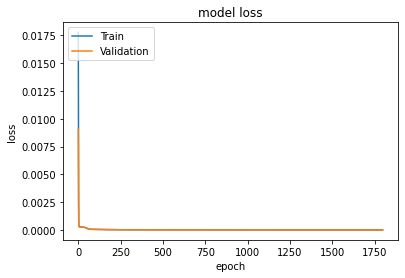

In [15]:
# summarize history for accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
# Save the model
model.save('plastic_strain_predictor_model_von_mises_31_01_2025.h5')
#print("Model saved as 'plastic_strain_predictor_model.h5'")

with open('scaler_X_von_mises_31_01_2025.pkl', 'wb') as file:
    pickle.dump(scaler_X, file)
with open('scaler_y_von_mises_31_01_2025.pkl', 'wb') as file:
    pickle.dump(scaler_y, file)